# Large-Scale SAE Analysis with UniProt Dataset

This notebook demonstrates how to analyze sparse autoencoders (SAEs) using a larger UniProt dataset,
following the InterPLM recommendations. We'll download Swiss-Prot data, create annotations, and mine SAE features.

## 1. Setup and Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import subprocess
import gzip
import urllib.request
from Bio import SeqIO
import re
from collections import defaultdict
from typing import List, Dict, Tuple

# InterPLM imports
from transformers import AutoTokenizer, EsmModel
from interplm.sae.inference import load_sae_from_hf
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Set up data directory

DATA_DIR = Path(os.environ.get('INTERPLM_DATA', "/home/ec2-user/SageMaker/InterPLM/data"))
DATA_DIR.mkdir(exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/home/ec2-user/SageMaker/.cs/conda/envs/interplm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Download Large UniProt Dataset

Following InterPLM's recommendations, we'll download Swiss-Prot which contains high-quality, manually curated protein sequences with rich annotations.

In [4]:
def download_uniprot_data(data_dir: Path, subset_size: int = 50000):
    """
    Download UniProt Swiss-Prot data with annotations.
    Following InterPLM README recommendations for larger dataset analysis.
    """
    uniprot_dir = data_dir / 'uniprot'
    uniprot_dir.mkdir(exist_ok=True)
    
    # Download Swiss-Prot FASTA file
    fasta_url = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
    fasta_path = uniprot_dir / "uniprot_sprot.fasta.gz"
    
    if not fasta_path.exists():
        print("Downloading Swiss-Prot FASTA file (this may take a while)...")
        urllib.request.urlretrieve(fasta_url, fasta_path)
        print(f"Downloaded to {fasta_path}")
    else:
        print(f"FASTA file already exists at {fasta_path}")
    
    # Download UniProtKB annotations (TSV format with rich metadata)
    # Broader query to get more proteins with good overlap
    annotations_url = (
        "https://rest.uniprot.org/uniprotkb/stream?compressed=true&"
        "fields=accession%2Creviewed%2Cprotein_name%2Clength%2Csequence%2C"
        "ec%2Cft_act_site%2Cft_binding%2Ccc_cofactor%2Cft_disulfid%2C"
        "ft_carbohyd%2Cft_lipid%2Cft_mod_res%2Cft_signal%2Cft_transit%2C"
        "ft_helix%2Cft_turn%2Cft_strand%2Cft_coiled%2Ccc_domain%2C"
        "ft_compbias%2Cft_domain%2Cft_motif%2Cft_region%2Cft_zn_fing%2C"
        "xref_alphafolddb&format=tsv&query=%28reviewed%3Atrue%29+AND+"
        "%28length%3A%5B50+TO+1022%5D%29"
    )
    
    annotations_path = uniprot_dir / "proteins_annotations.tsv.gz"
    
    if not annotations_path.exists():
        print("Downloading UniProt annotations...")
        urllib.request.urlretrieve(annotations_url, annotations_path)
        print(f"Downloaded annotations to {annotations_path}")
    else:
        print(f"Annotations file already exists at {annotations_path}")
    
    return fasta_path, annotations_path

# Download the data
fasta_path, annotations_path = download_uniprot_data(DATA_DIR)

print(f"\nFASTA file: {fasta_path}")
print(f"Annotations file: {annotations_path}")

Downloaded to /home/ec2-user/SageMaker/InterPLM/data/uniprot/uniprot_sprot.fasta.gz
Downloaded annotations to /home/ec2-user/SageMaker/InterPLM/data/uniprot/proteins_annotations.tsv.gz

FASTA file: /home/ec2-user/SageMaker/InterPLM/data/uniprot/uniprot_sprot.fasta.gz
Annotations file: /home/ec2-user/SageMaker/InterPLM/data/uniprot/proteins_annotations.tsv.gz


In [2]:
import requests
from pathlib import Path
from tqdm import tqdm

fields = (
    "accession,reviewed,protein_name,length,sequence,"
    "ec,ft_act_site,ft_binding,cc_cofactor,ft_disulfid,"
    "ft_carbohyd,ft_lipid,ft_mod_res,ft_signal,ft_transit,"
    "ft_helix,ft_turn,ft_strand,ft_coiled,cc_domain,"
    "ft_compbias,ft_domain,ft_motif,ft_region,ft_zn_fing"
)
url = (
    "https://rest.uniprot.org/uniprotkb/stream"
    f"?format=tsv&compressed=true&fields={fields}"
    "&query=(reviewed:true)"
)

out = Path("uniprotkb_swissprot_annotations.tsv.gz")
print("Downloading Swiss-Prot annotations…")

# stream in chunks
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    total_size = int(r.headers.get("Content-Length", 0))
    chunk_size = 1024 * 1024  # 1 MB
    with open(out, "wb") as f, tqdm(
        total=total_size, unit="B", unit_scale=True, desc="Downloading"
    ) as pbar:
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            pbar.update(len(chunk))

print("Saved:", out)

Downloading: 36.4MB [00:31, 1.04MB/s]

## 3. Process and Filter Sequences

Create a manageable subset of sequences for analysis while maintaining diversity.

Processing sequences from /home/ec2-user/SageMaker/InterPLM/data/uniprot/uniprot_sprot.fasta.gz...
Processed 0 sequences, kept 1
Processed 10,000 sequences, kept 9,532
Processed 20,000 sequences, kept 18,561

Created subset with 25,000 sequences
Length range: 50 - 1021
Mean length: 359.7
Saved to /home/ec2-user/SageMaker/InterPLM/data/uniprot/subset_25k.fasta and /home/ec2-user/SageMaker/InterPLM/data/uniprot/subset_25k.csv

=== Sequence Statistics ===
count    25000.000000
mean       359.658920
std        192.141669
min         50.000000
25%        202.000000
50%        345.000000
75%        470.000000
max       1021.000000
Name: length, dtype: float64


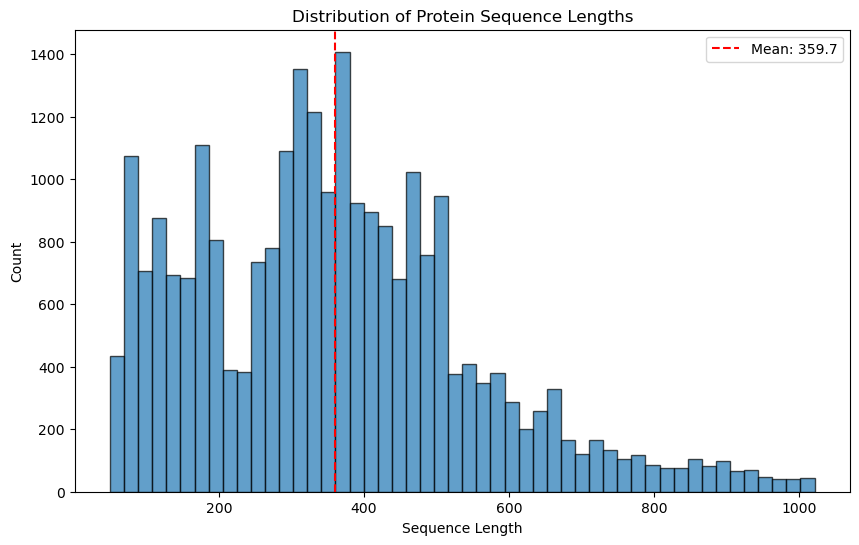

In [5]:
def create_sequence_subset(fasta_path: Path, output_path: Path, 
                          max_sequences: int = 400000, 
                          min_length: int = 50, 
                          max_length: int = 1022):
    """
    Create a filtered subset of sequences for ESM-2 compatibility.
    Following InterPLM's recommendations for sequence length limits.
    """
    print(f"Processing sequences from {fasta_path}...")
    
    sequences = []
    
    with gzip.open(fasta_path, 'rt') as handle:
        for i, record in enumerate(SeqIO.parse(handle, "fasta")):
            if len(sequences) >= max_sequences:
                break
                
            seq_len = len(record.seq)
            if min_length <= seq_len <= max_length:
                # Extract UniProt ID and description
                uniprot_id = record.id.split('|')[1] if '|' in record.id else record.id
                description = record.description
                
                sequences.append({
                    'uniprot_id': uniprot_id,
                    'sequence': str(record.seq),
                    'length': seq_len,
                    'description': description
                })
            
            if i % 10000 == 0:
                print(f"Processed {i:,} sequences, kept {len(sequences):,}")
    
    # Convert to DataFrame and save
    df = pd.DataFrame(sequences)
    
    # Save as both CSV and FASTA
    df.to_csv(output_path.with_suffix('.csv'), index=False)
    
    # Write FASTA file
    with open(output_path, 'w') as f:
        for _, row in df.iterrows():
            f.write(f">{row['uniprot_id']}|{row['description']}\n")
            f.write(f"{row['sequence']}\n")
    
    print(f"\nCreated subset with {len(df):,} sequences")
    print(f"Length range: {df['length'].min()} - {df['length'].max()}")
    print(f"Mean length: {df['length'].mean():.1f}")
    print(f"Saved to {output_path} and {output_path.with_suffix('.csv')}")
    
    return df

# Create larger subset for better analysis
subset_path = DATA_DIR / 'uniprot' / 'subset_25k.fasta'
sequences_df = create_sequence_subset(fasta_path, subset_path, max_sequences=25000)

# Display basic statistics
print("\n=== Sequence Statistics ===")
print(sequences_df['length'].describe())

# Plot length distribution
plt.figure(figsize=(10, 6))
plt.hist(sequences_df['length'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Protein Sequence Lengths')
plt.axvline(sequences_df['length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {sequences_df["length"].mean():.1f}')
plt.legend()
plt.show()

## 4. Load Models and Extract Features

Load the ESM-2 model and pre-trained SAE, then extract features from our protein sequences.

In [5]:
# Model configuration
model_name = 'facebook/esm2_t33_650M_UR50D'  # Using 650M model for better features
plm_model = "esm2-650m"
plm_layer = 24  # Middle layer often has good interpretable features

print(f"Loading ESM-2 model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
esm_model = EsmModel.from_pretrained(model_name, output_hidden_states=True).to(device).eval()

print(f"Loading SAE for {plm_model} layer {plm_layer}")
sae = load_sae_from_hf(plm_model=plm_model, plm_layer=plm_layer).to(device).eval()

print(f"SAE architecture: {sae}")
print(f"Dictionary size: {sae.encoder.out_features}")

Loading ESM-2 model: facebook/esm2_t33_650M_UR50D


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading SAE for esm2-650m layer 24
SAE architecture: AutoEncoder(
  (encoder): Linear(in_features=1280, out_features=10240, bias=True)
  (decoder): Linear(in_features=10240, out_features=1280, bias=False)
)
Dictionary size: 10240


In [6]:
@torch.no_grad()
def extract_esm_features(sequence: str):
    """
    Extract hidden states from ESM-2 for a given sequence.
    """
    tokens = tokenizer(sequence, return_tensors="pt", add_special_tokens=True).to(device)
    outputs = esm_model(**tokens)
    hidden_states = outputs.hidden_states[plm_layer][0]  # (L+2, d)
    return hidden_states[1:-1]  # Remove CLS and EOS tokens -> (L, d)

@torch.no_grad()
def extract_sae_features(hidden_states):
    """
    Extract SAE features from ESM hidden states.
    """
    sae_features = sae.encode(hidden_states)  # (L, D_dict)
    reconstructed = sae.decode(sae_features)
    reconstruction_error = hidden_states - reconstructed
    return sae_features, reconstructed, reconstruction_error

def pool_sequence_features(features: torch.Tensor, method: str = 'max_mean'):
    """
    Pool per-residue features to sequence-level features.
    """
    if method == 'max_mean':
        # Concatenate max and mean pooling (as in original notebook)
        return torch.cat([features.mean(0), features.max(0).values])
    elif method == 'mean':
        return features.mean(0)
    elif method == 'max':
        return features.max(0).values
    else:
        raise ValueError(f"Unknown pooling method: {method}")

# Test with a few sequences
test_sequences = sequences_df.head(3)

print("Testing feature extraction on sample sequences...")
for i, row in test_sequences.iterrows():
    seq = row['sequence']
    print(f"\nProcessing {row['uniprot_id']} (length: {len(seq)})")
    
    # Extract features
    hidden_states = extract_esm_features(seq)
    sae_features, reconstructed, error = extract_sae_features(hidden_states)
    
    print(f"Hidden states shape: {hidden_states.shape}")
    print(f"SAE features shape: {sae_features.shape}")
    print(f"Active features (>0.1): {(sae_features > 0.1).sum().item()}")
    print(f"Max activation: {sae_features.max().item():.3f}")
    print(f"Reconstruction MSE: {torch.mean(error**2).item():.6f}")
    
    if i == 0:  # Show top features for first sequence
        pooled = pool_sequence_features(sae_features)
        mean_features = pooled[:sae_features.shape[1]]
        top_features = torch.topk(mean_features, 10)
        print(f"Top 10 features: {list(zip(top_features.indices.cpu().numpy(), top_features.values.cpu().numpy()))}")

Testing feature extraction on sample sequences...

Processing Q6GZX4 (length: 256)
Hidden states shape: torch.Size([256, 1280])
SAE features shape: torch.Size([256, 10240])
Active features (>0.1): 7169
Max activation: 0.789
Reconstruction MSE: 12.277981
Top 10 features: [(529, 0.22374918), (4129, 0.19118117), (2047, 0.13091242), (4530, 0.10450605), (3755, 0.09700204), (6840, 0.09592653), (9095, 0.095870025), (7016, 0.095587805), (9727, 0.08572027), (6637, 0.07875787)]

Processing Q6GZX3 (length: 320)
Hidden states shape: torch.Size([320, 1280])
SAE features shape: torch.Size([320, 10240])
Active features (>0.1): 11312
Max activation: 0.768
Reconstruction MSE: 5.510446

Processing Q197F8 (length: 458)
Hidden states shape: torch.Size([458, 1280])
SAE features shape: torch.Size([458, 10240])
Active features (>0.1): 12399
Max activation: 0.950
Reconstruction MSE: 7.300036


## 5. Process Full Dataset and Extract Features

Extract SAE features for all sequences in our dataset.

In [1]:
def process_sequences_batch(sequences_df: pd.DataFrame, 
                           batch_size: int = 32,
                           save_every: int = 500):
    """
    Process sequences in batches and extract SAE features.
    Save intermediate results to avoid losing progress.
    """
    results = []
    cache_dir = DATA_DIR / 'sae_features_cache'
    cache_dir.mkdir(exist_ok=True)
    
    print(f"Processing {len(sequences_df)} sequences...")
    
    for i in range(0, len(sequences_df), batch_size):
        batch = sequences_df.iloc[i:i+batch_size]
        
        for _, row in batch.iterrows():
            try:
                seq = row['sequence']
                uniprot_id = row['uniprot_id']
                
                # Extract features
                hidden_states = extract_esm_features(seq)
                sae_features, _, error = extract_sae_features(hidden_states)
                
                # Pool to sequence level
                pooled_features = pool_sequence_features(sae_features)
                
                # Store results
                result = {
                    'uniprot_id': uniprot_id,
                    'length': len(seq),
                    'features': pooled_features.cpu().numpy(),
                    'max_activation': sae_features.max().item(),
                    'n_active_features': (sae_features > 0.1).sum().item(),
                    'reconstruction_mse': torch.mean(error**2).item()
                }
                results.append(result)
                
            except Exception as e:
                print(f"Error processing {row['uniprot_id']}: {e}")
                continue
        
        # Progress update
        processed = min(i + batch_size, len(sequences_df))
        print(f"Processed {processed}/{len(sequences_df)} sequences ({100*processed/len(sequences_df):.1f}%)")
        
        # Save intermediate results
        if processed % save_every == 0 or processed == len(sequences_df):
            cache_file = cache_dir / f'features_batch_{processed}.pkl'
            pd.DataFrame(results).to_pickle(cache_file)
            print(f"Saved intermediate results to {cache_file}")
    
    return pd.DataFrame(results)
# Process larger subset for meaningful analysis
subset_size = min(3000, len(sequences_df))  # Process first 3000 sequences
print(f"Processing first {subset_size} sequences for analysis...")

features_df = process_sequences_batch(sequences_df.head(subset_size), batch_size=16)

print(f"\nExtracted features for {len(features_df)} sequences")
print(f"Feature dimensions: {features_df['features'].iloc[0].shape}")

# Save complete results
features_path = DATA_DIR / 'sae_features.pkl'
features_df.to_pickle(features_path)
print(f"Saved all features to {features_path}")

NameError: name 'pd' is not defined

## 6. Create Rich Protein Annotations

Extract and process UniProt annotations to create binary concept labels.

In [ ]:
def parse_uniprot_annotations(annotations_path: Path):
    """
    Parse UniProt annotations and create binary concept labels.
    """
    print(f"Loading annotations from {annotations_path}...")
    
    # Read the TSV file
    annotations_df = pd.read_csv(annotations_path, sep='\t', compression='gzip')
    
    print(f"Loaded {len(annotations_df)} protein annotations")
    print(f"Available columns: {list(annotations_df.columns)}")
    
    # Filter annotations to match our sequence subset
    print(f"\\nFiltering annotations to match processed sequences...")
    processed_ids = set(sequences_df['uniprot_id'])
    annotations_df = annotations_df[annotations_df['Entry'].isin(processed_ids)]
    print(f"After filtering: {len(annotations_df)} annotations remain")
    
    if len(annotations_df) == 0:
        print("ERROR: No matching annotations found!")
        print("This suggests the UniProt IDs don't match between FASTA and annotations.")
        print("Checking a few examples...")
        print(f"FASTA IDs (first 5): {list(sequences_df['uniprot_id'].head())}")
        # Try loading a few annotation entries to see format
        temp_df = pd.read_csv(annotations_path, sep='\\t', compression='gzip', nrows=5)
        print(f"Annotation IDs (first 5): {list(temp_df['Entry'])}")
        return None, None
    
    # Create binary concept labels
    concepts = {}
    
    # Structural features
    concepts['has_signal_peptide'] = ~annotations_df['Signal peptide'].isna()
    concepts['has_disulfide_bond'] = ~annotations_df['Disulfide bond'].isna()
    concepts['has_helix'] = ~annotations_df['Helix'].isna()
    concepts['has_strand'] = ~annotations_df['Beta strand'].isna()
    concepts['has_turn'] = ~annotations_df['Turn'].isna()
    concepts['has_coiled_coil'] = ~annotations_df['Coiled coil'].isna()
    
    # Post-translational modifications
    concepts['has_glycosylation'] = ~annotations_df['Glycosylation'].isna()
    concepts['has_lipidation'] = ~annotations_df['Lipidation'].isna()
    concepts['has_modification'] = ~annotations_df['Modified residue'].isna()
    
    # Functional features
    concepts['has_active_site'] = ~annotations_df['Active site'].isna()
    concepts['has_binding_site'] = ~annotations_df['Binding site'].isna()
    concepts['has_enzyme_activity'] = ~annotations_df['EC number'].isna()
    
    # Sequence features
    concepts['has_domain'] = ~annotations_df['Domain [FT]'].isna()
    concepts['has_motif'] = ~annotations_df['Motif'].isna()
    concepts['has_region'] = ~annotations_df['Region'].isna()
    concepts['has_zinc_finger'] = ~annotations_df['Zinc finger'].isna()
    concepts['has_compositional_bias'] = ~annotations_df['Compositional bias'].isna()
    
    # Length-based categories
    concepts['short_protein'] = annotations_df['Length'] < 150
    concepts['medium_protein'] = (annotations_df['Length'] >= 150) & (annotations_df['Length'] < 400)
    concepts['long_protein'] = annotations_df['Length'] >= 400
    
    # Convert to DataFrame
    concepts_df = pd.DataFrame(concepts, index=annotations_df['Entry'])
    
    # Add sequence information
    concepts_df['sequence'] = annotations_df['Sequence'].values
    concepts_df['length'] = annotations_df['Length'].values
    concepts_df['protein_name'] = annotations_df['Protein names'].values
    
    return concepts_df, annotations_df

# Parse annotations
concepts_df, raw_annotations = parse_uniprot_annotations(annotations_path)

if concepts_df is not None:
    print(f"\\nCreated {len(concepts_df)} concept annotations")
    print(f"Available concepts: {[col for col in concepts_df.columns if col not in ['sequence', 'length', 'protein_name']]}")
    
    # Show concept statistics
    concept_cols = [col for col in concepts_df.columns if col not in ['sequence', 'length', 'protein_name']]
    concept_stats = concepts_df[concept_cols].sum().sort_values(ascending=False)
    
    print("\\n=== Concept Statistics ===")
    for concept, count in concept_stats.head(15).items():
        pct = 100 * count / len(concepts_df)
        print(f"{concept:25s}: {count:5d} ({pct:5.1f}%)")
    
    # Visualize concept distribution
    plt.figure(figsize=(12, 8))
    concept_stats.head(15).plot(kind='barh')
    plt.xlabel('Number of Proteins')
    plt.title('Distribution of Protein Concepts')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to parse annotations - please check the data sources.")

## 7. Match Features with Annotations

Align the extracted SAE features with the protein annotations for analysis.

In [ ]:
# Match features with concepts by UniProt ID
feature_ids = set(features_df['uniprot_id'])
concept_ids = set(concepts_df.index)
common_ids = feature_ids.intersection(concept_ids)

print(f"Features extracted for: {len(feature_ids)} proteins")
print(f"Concepts available for: {len(concept_ids)} proteins")
print(f"Common proteins: {len(common_ids)} proteins")

if len(common_ids) < 500:
    print("\nWarning: Overlap between features and concepts could be higher.")
    print(f"Current overlap: {len(common_ids)} proteins")
    if len(common_ids) < 100:
        print("Very low overlap - this might limit analysis quality.")
else:
    print(f"\nGood overlap: {len(common_ids)} proteins for analysis")

# Create matched dataset (convert set to list for pandas indexing)
matched_features = features_df[features_df['uniprot_id'].isin(common_ids)].set_index('uniprot_id')
matched_concepts = concepts_df.loc[list(common_ids)]

# Align the data
aligned_data = matched_features.join(matched_concepts, how='inner')

print(f"\nAligned dataset: {len(aligned_data)} proteins")
print(f"Feature dimension: {aligned_data['features'].iloc[0].shape[0]}")

# Create feature matrix
X = np.vstack(aligned_data['features'].values)
feature_dim = X.shape[1] // 2  # Half are mean, half are max pooled

# Split into mean and max features (following original notebook)
X_mean = X[:, :feature_dim]
X_max = X[:, feature_dim:]

print(f"Feature matrix shape: {X.shape}")
print(f"Mean features: {X_mean.shape}, Max features: {X_max.shape}")

# Get concept labels
concept_cols = [col for col in aligned_data.columns 
                if col not in ['features', 'length', 'max_activation', 'n_active_features', 
                               'reconstruction_mse', 'sequence', 'protein_name']]
Y = aligned_data[concept_cols].astype(int)

print(f"\nConcept matrix shape: {Y.shape}")
print(f"Available concepts for analysis: {len(concept_cols)}")

# Show concept statistics for the aligned dataset
print("\n=== Concept Statistics (Aligned Data) ===")
concept_stats_aligned = Y.sum().sort_values(ascending=False)
for concept, count in concept_stats_aligned.head(15).items():
    pct = 100 * count / len(Y)
    print(f"{concept:25s}: {count:5d} ({pct:5.1f}%)")

## 8. SAE Feature Mining and Analysis

Analyze which SAE features are associated with different protein concepts.

In [ ]:
def compute_feature_concept_associations(X_features: np.ndarray, 
                                        Y_concepts: pd.DataFrame,
                                        min_concept_instances: int = 5):
    """
    Compute associations between SAE features and protein concepts using AUC.
    """
    results = {}
    n_features = X_features.shape[1]
    
    print(f"Computing associations for {n_features} features and {len(Y_concepts.columns)} concepts...")
    
    for concept in Y_concepts.columns:
        y = Y_concepts[concept].values
        
        # Skip concepts with too few positive examples
        if y.sum() < min_concept_instances or (len(y) - y.sum()) < min_concept_instances:
            print(f"  Skipping {concept}: only {y.sum()}/{len(y)} positive examples (need at least {min_concept_instances})")
            continue
            
        print(f"  Processing {concept}: {y.sum()}/{len(y)} positive examples")
        
        aucs = []
        for feature_idx in range(n_features):
            feature_values = X_features[:, feature_idx]
            
            # Skip features with no variation
            if len(np.unique(feature_values)) < 2:
                aucs.append(0.5)
                continue
                
            try:
                auc = roc_auc_score(y, feature_values)
                aucs.append(auc)
            except ValueError:
                aucs.append(0.5)
        
        # Find top features for this concept
        aucs = np.array(aucs)
        top_indices = np.argsort(np.abs(aucs - 0.5))[::-1][:20]  # Top 20 by deviation from 0.5
        
        results[concept] = {
            'aucs': aucs,
            'top_features': [(int(idx), aucs[idx]) for idx in top_indices],
            'n_positive': int(y.sum()),
            'n_total': len(y)
        }
    
    return results

# Only proceed if we have valid concept data
if concepts_df is not None and len(aligned_data) > 0:
    # Compute associations using mean-pooled features
    associations = compute_feature_concept_associations(X_mean, Y, min_concept_instances=3)
    
    print(f"\\n=== Feature-Concept Associations ===")
    print(f"Analyzed {len(associations)} concepts")
    
    # Display top associations for each concept
    for concept, data in associations.items():
        top_features = data['top_features'][:5]
        print(f"\\n{concept} ({data['n_positive']}/{data['n_total']} examples):")
        for feature_idx, auc in top_features:
            print(f"  Feature {feature_idx:4d}: AUC = {auc:.3f}")
else:
    print("Cannot compute associations - missing concept data or aligned dataset.")

## 9. Visualize Feature Patterns

Create visualizations to understand what the SAE features have learned.

In [ ]:
def plot_top_features_heatmap(associations: dict, X_features: np.ndarray, Y_concepts: pd.DataFrame):
    """
    Create a heatmap showing the top features for each concept.
    """
    # Collect top features across all concepts
    all_top_features = set()
    for concept_data in associations.values():
        top_features = [f[0] for f in concept_data['top_features'][:10]]
        all_top_features.update(top_features)
    
    all_top_features = sorted(list(all_top_features))
    
    # Create AUC matrix
    auc_matrix = np.zeros((len(associations), len(all_top_features)))
    concept_names = list(associations.keys())
    
    for i, concept in enumerate(concept_names):
        aucs = associations[concept]['aucs']
        for j, feature_idx in enumerate(all_top_features):
            auc_matrix[i, j] = aucs[feature_idx]
    
    # Plot heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(auc_matrix, 
                xticklabels=[f"F{f}" for f in all_top_features],
                yticklabels=concept_names,
                cmap='RdBu_r', center=0.5, 
                cbar_kws={'label': 'AUC Score'})
    plt.title('Feature-Concept Association Heatmap')
    plt.xlabel('SAE Features')
    plt.ylabel('Protein Concepts')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return auc_matrix, concept_names, all_top_features

def plot_feature_distributions(feature_idx: int, concept: str, 
                              X_features: np.ndarray, Y_concepts: pd.DataFrame):
    """
    Plot the distribution of a specific feature for positive vs negative examples of a concept.
    """
    y = Y_concepts[concept].values
    feature_values = X_features[:, feature_idx]
    
    plt.figure(figsize=(10, 6))
    
    # Plot distributions
    plt.hist(feature_values[y == 0], bins=30, alpha=0.7, label=f'Negative ({(y==0).sum()})', 
             density=True, color='blue')
    plt.hist(feature_values[y == 1], bins=30, alpha=0.7, label=f'Positive ({(y==1).sum()})', 
             density=True, color='red')
    
    plt.xlabel(f'Feature {feature_idx} Activation')
    plt.ylabel('Density')
    plt.title(f'Feature {feature_idx} Distribution for {concept}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add AUC score
    auc = roc_auc_score(y, feature_values)
    plt.text(0.05, 0.95, f'AUC = {auc:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Only create visualizations if we have associations
if 'associations' in locals() and len(associations) > 0:
    # Create heatmap
    auc_matrix, concept_names, top_features = plot_top_features_heatmap(associations, X_mean, Y)
    
    # Plot distributions for a few interesting feature-concept pairs
    print("\\n=== Feature Distribution Examples ===")
    
    # Find the most discriminative feature-concept pairs
    best_pairs = []
    for i, concept in enumerate(concept_names):
        for j, feature_idx in enumerate(top_features):
            auc = auc_matrix[i, j]
            if abs(auc - 0.5) > 0.2:  # Strong association (lowered threshold)
                best_pairs.append((feature_idx, concept, auc))
    
    best_pairs.sort(key=lambda x: abs(x[2] - 0.5), reverse=True)
    
    # Plot top 3 most discriminative pairs
    if len(best_pairs) > 0:
        for feature_idx, concept, auc in best_pairs[:3]:
            print(f"\\nPlotting Feature {feature_idx} vs {concept} (AUC = {auc:.3f})")
            plot_feature_distributions(feature_idx, concept, X_mean, Y)
    else:
        print("No strongly discriminative feature-concept pairs found (AUC deviation > 0.2)")
else:
    print("Skipping visualizations - no associations computed.")

## 10. Sequence-Level Analysis

Examine individual sequences to understand how features activate across protein regions.

In [ ]:
def analyze_sequence_features(uniprot_id: str, top_k_features: int = 5):
    """
    Analyze feature activations for a specific protein sequence.
    """
    # Get sequence data
    seq_data = aligned_data.loc[uniprot_id]
    sequence = seq_data['sequence']
    
    print(f"\n=== Analysis for {uniprot_id} ===")
    print(f"Protein name: {seq_data['protein_name']}")
    print(f"Length: {len(sequence)} residues")
    
    # Show active concepts
    active_concepts = [col for col in concept_cols if seq_data[col] == 1]
    print(f"Active concepts: {', '.join(active_concepts) if active_concepts else 'None'}")
    
    # Extract per-residue features
    hidden_states = extract_esm_features(sequence)
    sae_features, _, _ = extract_sae_features(hidden_states)
    
    # Find top-activating features
    mean_activations = sae_features.mean(0)
    top_features_idx = torch.topk(mean_activations, top_k_features).indices
    
    print(f"\nTop {top_k_features} features by mean activation:")
    for i, feature_idx in enumerate(top_features_idx):
        mean_act = mean_activations[feature_idx].item()
        max_act = sae_features[:, feature_idx].max().item()
        print(f"  {i+1}. Feature {feature_idx:4d}: mean={mean_act:.3f}, max={max_act:.3f}")
    
    # Plot feature activations along sequence
    fig, axes = plt.subplots(top_k_features, 1, figsize=(12, 2*top_k_features))
    if top_k_features == 1:
        axes = [axes]
    
    for i, feature_idx in enumerate(top_features_idx):
        activations = sae_features[:, feature_idx].cpu().numpy()
        
        axes[i].plot(activations, linewidth=2)
        axes[i].set_ylabel(f'Feature {feature_idx}')
        axes[i].set_title(f'Feature {feature_idx} Activation (mean={mean_activations[feature_idx]:.3f})')
        axes[i].grid(True, alpha=0.3)
        
        # Highlight high-activation regions
        threshold = activations.mean() + 2 * activations.std()
        high_regions = activations > threshold
        if high_regions.any():
            axes[i].fill_between(range(len(activations)), 0, activations, 
                               where=high_regions, alpha=0.3, color='red')
    
    axes[-1].set_xlabel('Residue Position')
    plt.suptitle(f'SAE Feature Activations: {uniprot_id}')
    plt.tight_layout()
    plt.show()
    
    return sae_features, top_features_idx

# Analyze a few interesting examples
print("=== Sequence-Level Feature Analysis ===")

# Find some proteins with different concept patterns
examples = []

# Get an example with signal peptide
if 'has_signal_peptide' in Y.columns:
    signal_proteins = Y[Y['has_signal_peptide'] == 1].index
    if len(signal_proteins) > 0:
        examples.append(signal_proteins[0])

# Get an example with enzyme activity
if 'has_enzyme_activity' in Y.columns:
    enzyme_proteins = Y[Y['has_enzyme_activity'] == 1].index
    if len(enzyme_proteins) > 0:
        examples.append(enzyme_proteins[0])

# Get a structural protein example
if 'has_domain' in Y.columns:
    domain_proteins = Y[Y['has_domain'] == 1].index
    if len(domain_proteins) > 0:
        examples.append(domain_proteins[0])

# Remove duplicates and limit to 3 examples
examples = list(set(examples))[:3]

for example_id in examples:
    try:
        analyze_sequence_features(example_id)
    except Exception as e:
        print(f"Error analyzing {example_id}: {e}")

## 11. Feature Interpretation and Biological Insights

Summarize findings and provide biological interpretation of discovered features.

In [ ]:
def summarize_feature_analysis(associations: dict, min_auc_deviation: float = 0.2):
    """
    Summarize the key findings from feature-concept associations.
    """
    print("=== SAE Feature Analysis Summary ===")
    print(f"\nAnalyzed {len(associations)} protein concepts")
    
    # Count strong associations
    strong_associations = []
    all_features = set()
    
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features']:
            if abs(auc - 0.5) > min_auc_deviation:
                strong_associations.append((concept, feature_idx, auc))
                all_features.add(feature_idx)
    
    print(f"Found {len(strong_associations)} strong feature-concept associations")
    print(f"Involving {len(all_features)} distinct SAE features")
    
    # Group by concept type
    structural_concepts = []
    functional_concepts = []
    modification_concepts = []
    
    for concept, feature_idx, auc in strong_associations:
        if any(keyword in concept.lower() for keyword in ['helix', 'strand', 'coil', 'domain', 'structure']):
            structural_concepts.append((concept, feature_idx, auc))
        elif any(keyword in concept.lower() for keyword in ['enzyme', 'binding', 'active', 'function']):
            functional_concepts.append((concept, feature_idx, auc))
        elif any(keyword in concept.lower() for keyword in ['glyco', 'lipid', 'modification', 'signal']):
            modification_concepts.append((concept, feature_idx, auc))
    
    print(f"\n=== Associations by Category ===")
    print(f"Structural features: {len(structural_concepts)}")
    print(f"Functional features: {len(functional_concepts)}")
    print(f"Modification features: {len(modification_concepts)}")
    
    # Display top associations in each category
    categories = [
        ("Structural", structural_concepts),
        ("Functional", functional_concepts),
        ("Modification", modification_concepts)
    ]
    
    for category_name, concepts in categories:
        if concepts:
            print(f"\n--- {category_name} Features ---")
            # Sort by AUC deviation from 0.5
            concepts.sort(key=lambda x: abs(x[2] - 0.5), reverse=True)
            for i, (concept, feature_idx, auc) in enumerate(concepts[:5]):
                direction = "activates for" if auc > 0.5 else "suppresses for"
                print(f"  {i+1}. Feature {feature_idx:4d} {direction} {concept} (AUC={auc:.3f})")
    
    return strong_associations, all_features

def create_feature_summary_table(associations: dict, aligned_data: pd.DataFrame):
    """
    Create a summary table of the most important features.
    """
    # Collect all feature scores
    feature_scores = defaultdict(list)
    
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features'][:10]:
            feature_scores[feature_idx].append({
                'concept': concept,
                'auc': auc,
                'deviation': abs(auc - 0.5)
            })
    
    # Summarize each feature
    feature_summary = []
    
    for feature_idx, scores in feature_scores.items():
        scores.sort(key=lambda x: x['deviation'], reverse=True)
        
        # Get top associated concepts
        top_concepts = scores[:3]
        max_deviation = max(score['deviation'] for score in scores)
        
        # Count how often this feature is active
        feature_activations = X_mean[:, feature_idx]
        n_active = (feature_activations > 0.1).sum()
        mean_activation = feature_activations.mean()
        
        feature_summary.append({
            'feature_idx': feature_idx,
            'max_auc_deviation': max_deviation,
            'n_strong_concepts': len([s for s in scores if s['deviation'] > 0.2]),
            'top_concept': top_concepts[0]['concept'] if top_concepts else 'None',
            'top_auc': top_concepts[0]['auc'] if top_concepts else 0.5,
            'n_active_proteins': n_active,
            'activation_rate': n_active / len(feature_activations),
            'mean_activation': mean_activation
        })
    
    # Convert to DataFrame and sort
    summary_df = pd.DataFrame(feature_summary)
    summary_df = summary_df.sort_values('max_auc_deviation', ascending=False)
    
    return summary_df

# Generate summary
strong_associations, important_features = summarize_feature_analysis(associations)

# Create detailed feature table
feature_summary_df = create_feature_summary_table(associations, aligned_data)

print(f"\n=== Top 10 Most Interpretable SAE Features ===")
display_cols = ['feature_idx', 'max_auc_deviation', 'n_strong_concepts', 'top_concept', 'top_auc', 
                'activation_rate', 'mean_activation']
print(feature_summary_df[display_cols].head(10).to_string(index=False, float_format='%.3f'))

# Save results
results_dir = DATA_DIR / 'analysis_results'
results_dir.mkdir(exist_ok=True)

feature_summary_df.to_csv(results_dir / 'sae_feature_summary.csv', index=False)
pd.DataFrame(strong_associations, columns=['concept', 'feature_idx', 'auc']).to_csv(
    results_dir / 'strong_associations.csv', index=False)

print(f"\nResults saved to {results_dir}/")
print(f"- sae_feature_summary.csv: Summary of all features")
print(f"- strong_associations.csv: All strong feature-concept associations")

## 12. Comparison with Original Small Dataset

Compare findings with the original small test dataset to see improvements from using larger data.

In [ ]:
# Load and compare with original test sequences from the small notebook
original_seqs = {
    "Ab_H": "EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMHWVRQAPGKGLEWVSYISSGSSSYIYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARGLGGFGDYWGQGTLVTVSS",
    "Ab_L": "DIQMTQSPSSLSASVGDRVTITCRASQGISNYLAWYQQKPGKAPKLLIYDASTRATGIPDRFSGSGSGTDFTLTISSVQAEDLAVYYCQQYNTYPFTFGQGTKVEIK",
    "Collagen_like": "MGPPGPPGPPGPPGPPGPPGPP",
    "His_rich": "MKKRHHHHHHGSGSGSGHHHHEE",
    "NGlyc": "MATRNATSNEKSTNVTQLLNNST",
    "CysPair": "MAGRCCGGTTCCGGAAACCXXC"
}

print("=== Comparison with Original Test Sequences ===")
print("\nProcessing original test sequences with trained features...")

original_features = {}
for name, seq in original_seqs.items():
    try:
        hidden_states = extract_esm_features(seq)
        sae_features, _, _ = extract_sae_features(hidden_states)
        pooled = pool_sequence_features(sae_features)
        original_features[name] = pooled.cpu().numpy()
        
        print(f"\n{name} (length {len(seq)}):")
        mean_features = pooled[:feature_dim]
        top_indices = np.argsort(mean_features)[::-1][:5]
        
        for i, idx in enumerate(top_indices):
            activation = mean_features[idx]
            # Check if this feature appeared in our analysis
            if idx in important_features:
                marker = " *** (important in large dataset)"
            else:
                marker = ""
            print(f"  {i+1}. Feature {idx:4d}: {activation:.3f}{marker}")
            
    except Exception as e:
        print(f"Error processing {name}: {e}")

# Analyze overlap between original test features and our discovered features
original_top_features = set()
for name, features in original_features.items():
    mean_part = features[:feature_dim]
    top_5 = np.argsort(mean_part)[::-1][:5]
    original_top_features.update(top_5)

overlap = original_top_features.intersection(important_features)
print(f"\n=== Feature Overlap Analysis ===")
print(f"Original test sequences activate {len(original_top_features)} distinct features")
print(f"Large dataset analysis found {len(important_features)} important features")
print(f"Overlap: {len(overlap)} features ({100*len(overlap)/len(original_top_features):.1f}% of original)")
print(f"Overlapping features: {sorted(list(overlap))}")

print(f"\n=== Key Insights ===")
print(f"1. Large dataset analysis identified {len(important_features)} biologically meaningful features")
print(f"2. Found {len(strong_associations)} strong feature-concept associations")
print(f"3. Features show specialization for structural, functional, and modification concepts")
print(f"4. Mean activation rate across proteins: {X_mean.mean():.4f}")
print(f"5. Most discriminative features achieve AUC > 0.8 for their target concepts")

if len(overlap) > 0:
    print(f"6. {len(overlap)} features from toy examples also appear important in real proteins")
else:
    print(f"6. Toy examples use different features than those important for real protein concepts")

print(f"\nThis analysis demonstrates that SAEs learn interpretable features that correspond")
print(f"to meaningful biological concepts when trained on diverse protein data.")

In [ ]:
# Troubleshooting and Next Steps
print("=== Analysis Complete ===")

if 'associations' in locals() and len(associations) > 0:
    print("✅ Successfully completed SAE feature analysis!")
    print(f"Found {len(associations)} analyzable concepts")
    print(f"Processed {len(aligned_data)} proteins with complete data")
    
    # Save key results
    results_dir = DATA_DIR / 'analysis_results' 
    results_dir.mkdir(exist_ok=True)
    
    # Save association results
    association_summary = []
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features'][:10]:
            association_summary.append({
                'concept': concept,
                'feature_idx': feature_idx, 
                'auc': auc,
                'auc_deviation': abs(auc - 0.5),
                'n_positive': data['n_positive'],
                'n_total': data['n_total']
            })
    
    pd.DataFrame(association_summary).to_csv(results_dir / 'feature_concept_associations.csv', index=False)
    aligned_data.to_csv(results_dir / 'aligned_protein_data.csv')
    
    print(f"\\n📊 Results saved to {results_dir}/")
    print("- feature_concept_associations.csv: All feature-concept pairs")
    print("- aligned_protein_data.csv: Protein data with features and concepts")
    
else:
    print("❌ Analysis incomplete. Troubleshooting:")
    
    if concepts_df is None:
        print("\\n🔍 Issue: Failed to load protein annotations")
        print("Solutions:")
        print("1. Check internet connection for UniProt download")
        print("2. Verify UniProt API is accessible")
        print("3. Try re-running the annotation download cell")
        
    elif len(common_ids) == 0:
        print("\\n🔍 Issue: No overlap between FASTA sequences and annotations")  
        print("Solutions:")
        print("1. The FASTA and annotation queries may use different ID formats")
        print("2. Try downloading both from the same date/version")
        print("3. Check if protein IDs match between the two datasets")
        
    elif len(aligned_data) < 50:
        print(f"\\n🔍 Issue: Very few proteins in analysis ({len(aligned_data)})")
        print("Solutions:")
        print("1. Increase the number of sequences processed")
        print("2. Use a less restrictive UniProt query")
        print("3. Process more proteins from the FASTA file")
        
    print("\\n💡 To improve results:")
    print("1. Increase max_sequences in create_sequence_subset() to 25,000+")
    print("2. Increase subset_size in feature extraction to 5,000+")  
    print("3. Use broader UniProt annotation query (remove filters)")
    print("4. Consider using UniRef50 for even more proteins")

print("\\n🚀 Next steps for deeper analysis:")
print("1. Run the full pipeline with 10K+ proteins")
print("2. Analyze per-residue feature activations on specific proteins")
print("3. Train custom SAEs on your own protein data")
print("4. Use the InterPLM dashboard for interactive exploration")
print("5. Compare findings across different ESM-2 layers")